# ML Classification

In [2]:
# Imports
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

from data_loading import demographics, weather, rats, geography, ml

data_folder_path = "C:/Users/jerom/OneDrive/Documents/Uni/MGI/RS and GIS integration/ACT Python Environment/local_data/"

rat_df = rats.load_rm_data(data_folder_path + "Rat_Monitor_export.xlsx")
pc_rat_df = rats.group_by_postcode(rat_df)
month_rat_df = rats.group_by_month(rat_df)

cbs_df = demographics.load_cbs_data(data_folder_path + "cbs_pc4_2024_v1.gpkg", drop_empty_cols=True)
month_temp_df = weather.load_cnt_data(data_folder_path + "cnt.dat")
bins_df = geography.load_bin_data(data_folder_path + "PC4_areas_bak_put_water.csv")
manholes_df = geography.load_manhole_data(data_folder_path + "PC4_areas_bak_put_water.csv")
water_df = geography.load_water_data(data_folder_path + "PC4_areas_bak_put_water.csv")
green_df = geography.load_green_data(data_folder_path + "PC4_GreeneryPercentages.csv")


c:\Users\jerom\OneDrive\Documents\Uni\MGI\RS and GIS integration\ACT Python Environment\act2025webapp\data_exploration\data_loading\weather.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cnt_df = pd.read_csv(path, delim_whitespace=True, skiprows=8, names=col_names)


## Data Preperation

### Merged Features

In [3]:
# Merge data and prepare features
cbs_df = demographics.drop_empty_cols(cbs_df, max_na_percentage=0.05)
cbs_df = demographics.aantal_to_percentage(cbs_df)
ml_merged_df = ml.merge_data(pc_rat_df, [cbs_df, bins_df, manholes_df, water_df, green_df], dropna=True)

# Set features to exclude in ML
exclude_features = ['TOTAAL', 'area_km2', 'geometry', 'stedelijkheid', 'EEN_OF_MEER', 'MEER_DAN_VIJF']

X, y = ml.prepare_clf_data(ml_merged_df, 'TOTAAL', exclude_features=exclude_features)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

### Spatio-temporal Lags

In [12]:
import libpysal
from libpysal.weights import Queen

rat_df['month'] = rat_df['Datum waarneming'].dt.to_period('M').dt.to_timestamp()

# Create index for all months and all postcodes
all_months = pd.date_range(rat_df['month'].min(), rat_df['month'].max(), freq='MS')
all_postcodes = cbs_df.index.unique()
idx = pd.MultiIndex.from_product([all_months, all_postcodes], names=['month', 'postcode'])

# Group rat sightinhs by month and postcode
ml_monthly_df = (
    rat_df.groupby(['month', 'Pc4code'])
    .size()
    .reset_index(name='TOTAAL')
    .rename(columns={'Pc4code': 'postcode'})
)

# Reindex to include all months and postcods, filling with 0 for all non rat sightings
ml_monthly_df = ml_monthly_df.set_index(['month', 'postcode']).reindex(idx, fill_value=0).reset_index()

# Sort for lag calculation
ml_monthly_df = ml_monthly_df.sort_values(['postcode', 'month'])

# Add temporal lags (e.g., previous month and two months ago)
ml_monthly_df['TOTAAL_lag1'] = ml_monthly_df.groupby('postcode')['TOTAAL'].shift(1)
ml_monthly_df['TOTAAL_lag2'] = ml_monthly_df.groupby('postcode')['TOTAAL'].shift(2)

# Add rolling statistics for
ml_monthly_df['rolling_mean'] = (
    ml_monthly_df.groupby('postcode')['TOTAAL']
    .transform(lambda x: x.shift(1).rolling(window=6, min_periods=1).mean())
)
ml_monthly_df['rolling_max'] = (
    ml_monthly_df.groupby('postcode')['TOTAAL']
    .transform(lambda x: x.shift(1).rolling(window=6, min_periods=1).max())
)
ml_monthly_df['rolling_std'] = (
    ml_monthly_df.groupby('postcode')['TOTAAL']
    .transform(lambda x: x.shift(1).rolling(window=6, min_periods=1).std())
)

# Merge with geometry
ml_monthly_gdf = ml_monthly_df.merge(cbs_df[['geometry']], left_on='postcode', right_index=True)
ml_monthly_gdf = gpd.GeoDataFrame(ml_monthly_gdf, geometry='geometry')

# Create spatial weights (once)
w = Queen.from_dataframe(cbs_df)

# Compute spatial lag for each month
ml_monthly_gdf['spatial_lag'] = 0.0
for date in ml_monthly_gdf['month'].unique():
    mask = ml_monthly_gdf['month'] == date
    df_month = ml_monthly_gdf[mask].set_index('postcode').reindex(cbs_df.index)
    df_month.loc[:, df_month.columns != 'geometry'] = df_month.loc[:, df_month.columns != 'geometry'].fillna(0)
    lag = libpysal.weights.lag_spatial(w, df_month['TOTAAL'])
    ml_monthly_gdf.loc[mask, 'spatial_lag'] = lag

# Create a column with the spatial lag of the previous month to prevent data leakage
ml_monthly_gdf = ml_monthly_gdf.sort_values(['postcode', 'month'])
ml_monthly_gdf['spatial_lag_prev'] = ml_monthly_gdf.groupby('postcode')['spatial_lag'].shift(1)


C:\Users\jerom\AppData\Local\Temp\ipykernel_9020\2860694305.py:48: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(cbs_df)
c:\Users\jerom\OneDrive\Documents\Uni\MGI\RS and GIS integration\ACT Python Environment\.venv\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 34 disconnected components.
 There are 25 islands with ids: 294, 545, 1254, 1288, 1877, 2331, 2951, 2994, 3149, 3332, 3334, 3359, 3426, 3428, 3450, 3467, 3473, 3481, 3512, 3564, 3614, 3621, 3762, 3811, 3965.
  W.__init__(self, neighbors, ids=ids, **kw)


In [13]:

#Define features to use
features = ['TOTAAL_lag1', 'TOTAAL_lag2', 'rolling_mean', 
            'rolling_max', 'rolling_std', 'spatial_lag_prev', 'mean_temperature']

# Set features to exclude in ML
exclude_features = ['postcode', 'TOTAAL', 'area_km2', 
                    'geometry', 'stedelijkheid', 'EEN_OF_MEER', 
                    'MEER_DAN_VIJF', 'month', 'spatial_lag']

# Merge static features from ml_merged_df into each row of ml_monthly_gdf
ml_monthly_gdf = ml_monthly_gdf.merge(
    ml_merged_df.drop(columns=['TOTAAL', 'geometry'], errors='ignore'),  # drop columns you don't want duplicated
    on='postcode',
    how='left'
)

#ml_monthly_gdf = ml_monthly_gdf.merge(month_temp_df[['mean_temperature', 'date']], left_on='month', right_on='date', how='left')

X, y = ml.prepare_clf_data(ml_monthly_gdf, 'TOTAAL', exclude_features=exclude_features)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=16)

In [14]:
X.columns

Index(['TOTAAL_lag1', 'TOTAAL_lag2', 'rolling_mean', 'rolling_max',
       'rolling_std', 'spatial_lag_prev', 'aantal_inwoners',
       'percentage_geb_nederland_herkomst_nederland',
       'gemiddelde_huishoudensgrootte', 'aantal_woningen',
       'percentage_koopwoningen', 'omgevingsadressendichtheid',
       'inwoner_dichtheid', 'bouwjaar_gemiddeld', 'percentage_mannen',
       'percentage_vrouwen', 'percentage_inwoners_0_tot_15_jaar',
       'percentage_inwoners_15_tot_25_jaar',
       'percentage_inwoners_25_tot_45_jaar',
       'percentage_inwoners_45_tot_65_jaar',
       'percentage_inwoners_65_jaar_en_ouder', 'percentage_part_huishoudens',
       'percentage_eenpersoonshuishoudens',
       'percentage_meerpersoonshuishoudens_zonder_kind',
       'percentage_tweeouderhuishoudens', 'bins_per_km2', 'manholes_per_km2',
       'water_availability', 'green_percentage'],
      dtype='object')

## Models

### SVM

In [4]:
# Train and evaluate a Support Vector Machine (SVM) classifier
svc = SVC(random_state=42)
svc.fit(X_train, y_train)

# Predict and evaluate
y_pred_svc = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))

[[830   0]
 [139   0]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       830
           1       0.00      0.00      0.00       139

    accuracy                           0.86       969
   macro avg       0.43      0.50      0.46       969
weighted avg       0.73      0.86      0.79       969



c:\Users\jerom\OneDrive\Documents\Uni\MGI\RS and GIS integration\ACT Python Environment\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jerom\OneDrive\Documents\Uni\MGI\RS and GIS integration\ACT Python Environment\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jerom\OneDrive\Documents\Uni\MGI\RS and GIS integration\ACT Python Environment\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

In [125]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# Select only the majority class (e.g., no rat sightings) for training
X_train_majority = X_train[y_train == 0]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_majority)
X_test_scaled = scaler.transform(X_test)

# Fit One-Class SVM
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)  # nu is the expected proportion of outliers
ocsvm.fit(X_train_scaled)

# Predict: -1 = outlier (potential rare event), 1 = inlier (normal)
y_pred_ocsvm = ocsvm.predict(X_test_scaled)
# Convert to binary: 1 = rare event, 0 = normal
y_pred_rare = (y_pred_ocsvm == -1).astype(int)

# Compare to actual rare events
print(classification_report(y_test, y_pred_rare))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89       830
           1       0.11      0.06      0.08       139

    accuracy                           0.80       969
   macro avg       0.48      0.49      0.48       969
weighted avg       0.75      0.80      0.77       969



### Random Forest

In [45]:
# Hyperparameter cross-validation for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

clf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
[[228   1]
 [ 38   1]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       229
           1       0.50      0.03      0.05        39

    accuracy                           0.85       268
   macro avg       0.68      0.51      0.48       268
weighted avg       0.81      0.85      0.79       268



### Balanced Random Forest (Best)

In [15]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Train Balanced Random Forest
param_grid = {
    'n_estimators': [180],
    'max_depth': [4],
    'min_samples_split': [4]
}

brf = BalancedRandomForestClassifier(random_state=42)
grid_search = GridSearchCV(brf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

clf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Predict and evaluate
y_pred = (clf.predict_proba(X_test)[:, 1] > 0.8).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameters: {'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 180}
[[65756  2121]
 [   63   250]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     67877
           1       0.11      0.80      0.19       313

    accuracy                           0.97     68190
   macro avg       0.55      0.88      0.58     68190
weighted avg       0.99      0.97      0.98     68190



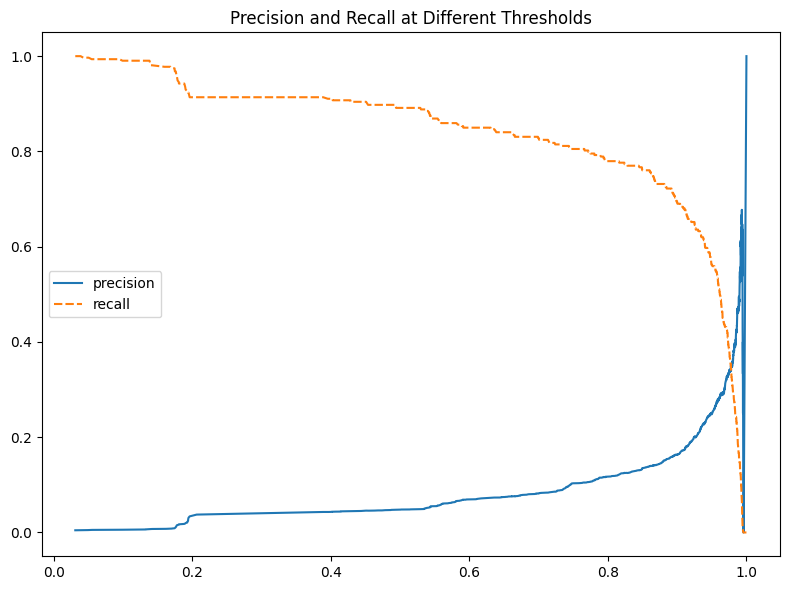

In [69]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities for the positive class
y_scores = clf.predict_proba(X_test)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

precision_recall_df = pd.DataFrame({'precision': precision, 'recall': recall}, index=np.append(thresholds, 1))

# Plot precision and recall for the specified thresholds
plt.figure(figsize=(8, 6))
sns.lineplot(precision_recall_df)
plt.title('Precision and Recall at Different Thresholds')
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False)

rolling_max                                       0.241801
rolling_mean                                      0.188707
rolling_std                                       0.179717
spatial_lag_prev                                  0.110193
TOTAAL_lag1                                       0.071969
TOTAAL_lag2                                       0.069453
aantal_woningen                                   0.021520
aantal_inwoners                                   0.020682
water_availability                                0.009886
green_percentage                                  0.008003
bouwjaar_gemiddeld                                0.007379
percentage_tweeouderhuishoudens                   0.006915
percentage_part_huishoudens                       0.006914
omgevingsadressendichtheid                        0.006703
inwoner_dichtheid                                 0.006311
percentage_inwoners_0_tot_15_jaar                 0.005436
percentage_eenpersoonshuishoudens                 0.0053

In [71]:
feature_importances[feature_importances > 0.02].index

Index(['TOTAAL_lag1', 'TOTAAL_lag2', 'rolling_mean_3', 'rolling_max_3',
       'rolling_std_3', 'spatial_lag_prev', 'aantal_inwoners',
       'aantal_woningen'],
      dtype='object')

### Boosting

In [8]:
import xgboost as xgb

# Define parameter grid for cross-validation
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Predict and evaluate
y_pred = best_xgb.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

c:\Users\jerom\OneDrive\Documents\Uni\MGI\RS and GIS integration\ACT Python Environment\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:20:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
[[798  32]
 [123  16]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       830
           1       0.33      0.12      0.17       139

    accuracy                           0.84       969
   macro avg       0.60      0.54      0.54       969
weighted avg       0.79      0.84      0.81       969



### Neural Network

In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid for MLPClassifier
param_grid = {
    'hidden_layer_sizes': [(100, 100, 100, 50, 50, 50,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'max_iter': [1000],
    'alpha': [0.0001, 0.001]
}

mlp = MLPClassifier(random_state=42)
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

mlp = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Predict and evaluate
y_pred = mlp.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100, 100, 50, 50, 50), 'max_iter': 1000, 'solver': 'adam'}
[[65831    10]
 [  291    22]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     65841
           1       0.69      0.07      0.13       313

    accuracy                           1.00     66154
   macro avg       0.84      0.54      0.56     66154
weighted avg       0.99      1.00      0.99     66154



## PCA

In [88]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Drop non-numeric columns and NaNs for PCA
X_pca = ml_monthly_gdf.drop(columns=exclude_features).select_dtypes(include=[np.number]).dropna()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Fit PCA
pca = PCA(n_components=8)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, index=X_pca.index)

# Explained variance
print("Explained variance ratio:", np.cumsum(pca.explained_variance_ratio_))

# Show the first few rows
pca_df.head()

Explained variance ratio: [0.32039273 0.45769071 0.58261973 0.66338067 0.70820741 0.74489241
 0.77941116 0.80987656]


,0,1,2,3,4,5,6,7
2,8.327133,0.353913,-3.325242,1.899998,-0.315145,2.470174,1.315668,-0.29901
3,8.327133,0.353913,-3.325242,1.899998,-0.315145,2.470174,1.315668,-0.29901
4,8.327133,0.353913,-3.325242,1.899998,-0.315145,2.470174,1.315668,-0.29901
5,8.327133,0.353913,-3.325242,1.899998,-0.315145,2.470174,1.315668,-0.29901
6,8.327133,0.353913,-3.325242,1.899998,-0.315145,2.470174,1.315668,-0.29901


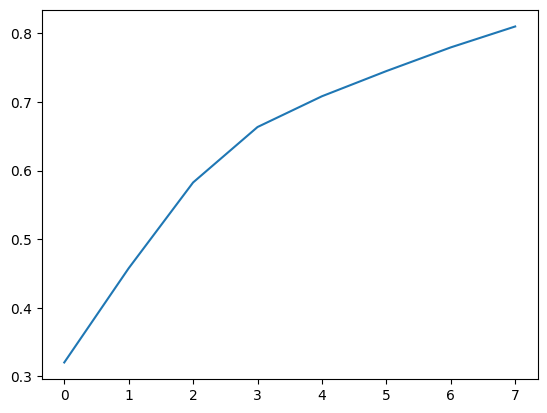

In [89]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
# No need to join y, as pca_df already contains the TOTAAL column from y
# Just split features and target directly

# Align indices and split features/target
X_pca_rf = pca_df.drop('TOTAAL', axis=1)
y_pca_rf = pca_df['TOTAAL'] 

# Align indices and join with target
X_pca_rf = pca_df.drop('TOTAAL', axis=1)
y_pca_rf = pca_df['TOTAAL']

# Train/test split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca_rf, y_pca_rf, stratify=y_pca_rf, random_state=42
)

# Train Balanced Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

brf = BalancedRandomForestClassifier(random_state=42)
grid_search = GridSearchCV(brf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_pca, y_train_pca)

clf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Predict and evaluate
y_pred_pca = clf.predict(X_test_pca)
print(confusion_matrix(y_test_pca, y_pred_pca))
print(classification_report(y_test_pca, y_pred_pca))

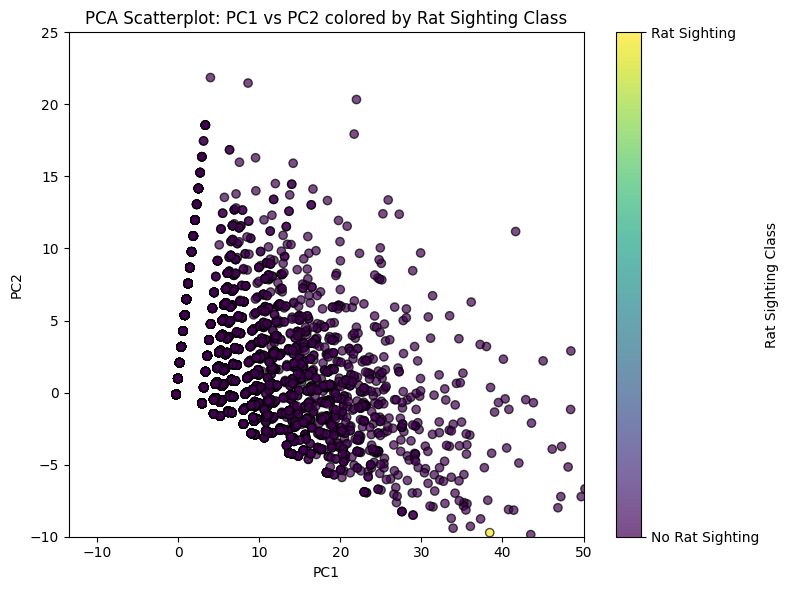

In [69]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    pca_df[0], 
    pca_df[1], 
    c=(pca_df['TOTAAL'] > 0).astype(int), 
    cmap='viridis', 
    alpha=0.7, 
    edgecolor='k'
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatterplot: PC1 vs PC2 colored by Rat Sighting Class')
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(['No Rat Sighting', 'Rat Sighting'])
cbar.set_label('Rat Sighting Class')
plt.xlim(right=50)
plt.ylim(bottom=-10, top=25)
plt.tight_layout()
plt.show()

## Kriging Hybrid Approach

In [208]:
from pykrige.ok import OrdinaryKriging

# 1. Get predicted probabilities and confidence from your trained classifier
y_proba = clf.predict_proba(X)[:, 1]  # Probability of class 1 (rat sighting)
confidence = np.abs((y_proba - 0.5) * 2)

# 2. Select high-confidence areas (e.g., proba < 0.1 or > 0.9)
high_conf_mask = (confidence > 0.7)   # Adjust threshold as needed

# 3. Prepare coordinates and values for kriging
gdf = gpd.GeoDataFrame(ml_merged_df[['TOTAAL', 'geometry']], geometry='geometry')
gdf['x'] = gdf['geometry'].centroid.x
gdf['y'] = gdf['geometry'].centroid.y

coords = np.vstack([gdf.loc[high_conf_mask, 'x'], gdf.loc[high_conf_mask, 'y']]).T
values = y_proba[high_conf_mask]

# 4. Fit kriging model using high-confidence predictions
OK = OrdinaryKriging(
    coords[:, 0], coords[:, 1], values,
    variogram_model='linear', verbose=False, enable_plotting=False
)

# 5. Predict for all areas (or just low-confidence ones)
gridx = gdf['x'].values
gridy = gdf['y'].values
z, ss = OK.execute('points', gridx, gridy)  # z = kriging predictions

# 6. Combine: use ML prediction where confident, kriging elsewhere
final_pred = np.where(high_conf_mask, y_proba, z)

# 7. Add results to your GeoDataFrame for mapping or analysis
gdf['ml_proba'] = y_proba
gdf['kriging_pred'] = z
gdf['final_pred'] = final_pred
gdf['high_confidence'] = high_conf_mask

C:\Users\jerom\AppData\Local\Temp\ipykernel_4712\2327785084.py:17: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1000 with 3 Axes> than <Figure size 1200x1000 with 3 Axes> which fig.colorbar is called on.
  plt.colorbar(sc, ax=ax, label='Kriging prediction')


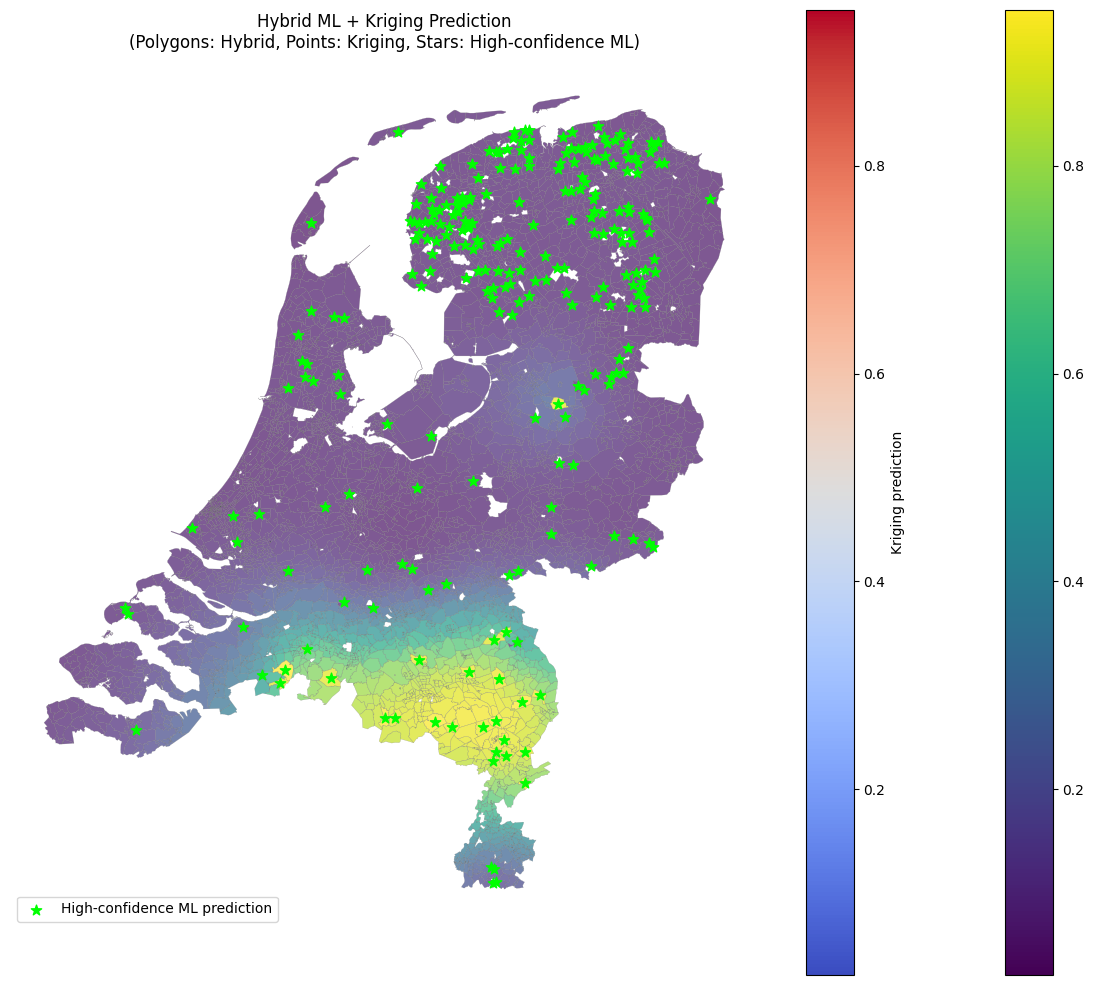

In [ ]:
# Plot both the kriging predictions as points and the polygons colored by hybrid prediction
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot polygons colored by hybrid prediction
gdf.plot(column='final_pred', cmap='viridis', legend=True, ax=ax, alpha=0.7, edgecolor='grey', linewidth=0.2)

# Highlight high-confidence centroids
ax.scatter(
    gdf.loc[high_conf_mask, 'x'],
    gdf.loc[high_conf_mask, 'y'],
    color='lime',
    s=60,
    marker='*',
    label='High-confidence ML prediction'
)

ax.set_title('Hybrid ML + Kriging Prediction\n(Polygons: Hybrid, Points: Kriging, Stars: High-confidence ML)')
ax.axis('off')
ax.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [207]:
threshold = 0.5 

y_pred_class = (gdf['final_pred'] > threshold).astype(int)

gdf['y_true'] = gdf['TOTAAL'].apply(lambda x: 1 if pd.notna(x) and x > 0 else 0)

print(confusion_matrix(gdf['y_true'], y_pred_class))
print(classification_report(gdf['y_true'], y_pred_class))

[[2723  186]
 [ 698  269]]
              precision    recall  f1-score   support

           0       0.80      0.94      0.86      2909
           1       0.59      0.28      0.38       967

    accuracy                           0.77      3876
   macro avg       0.69      0.61      0.62      3876
weighted avg       0.74      0.77      0.74      3876



## Plotting Model Results

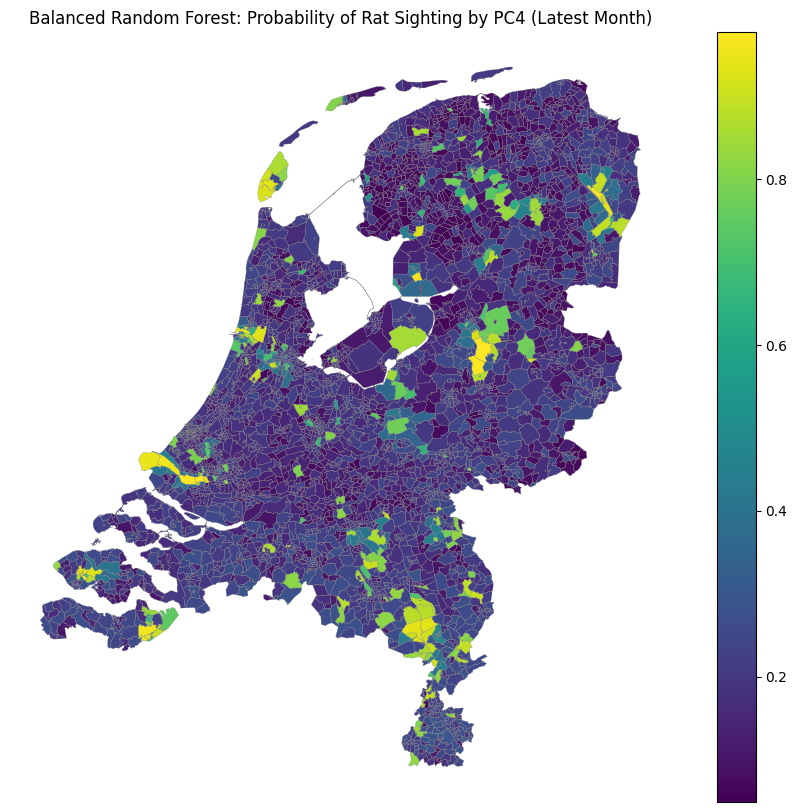

In [22]:
# Predict rat sighting probability for all PC4s using the latest available month in ml_monthly_gdf
# This ensures all lag/rolling features are present and match the training features

# Specify the target month (as a pandas Timestamp)
target_month = ml_monthly_gdf['month'].max() #pd.Timestamp('2023-08-01')  # Change this as needed

# Select rows for the target month and set index to postcode
target_df = ml_monthly_gdf[ml_monthly_gdf['month'] == target_month].set_index('postcode')

# Prepare features for prediction (must match training features)
X_pred = target_df.drop(columns=exclude_features, errors='ignore')

# Prepare GeoDataFrame for plotting
ml_plot_df = target_df[['geometry']].copy()
ml_plot_df['prob_positive'] = clf.predict_proba(X_pred)[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ml_plot_df.plot(
    column='prob_positive',
    cmap='viridis',
    linewidth=0.2,
    edgecolor='grey',
    ax=ax,
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "No data"
    }
)
ax.set_title('Balanced Random Forest: Probability of Rat Sighting by PC4 (Latest Month)')
ax.axis('off')
plt.show()

In [80]:
# Save the GeoDataFrame with predicted probabilities to a GeoPackage file
gpkg_path = data_folder_path + "rat_sighting_probabilities_" + str(target_month.date()) + ".gpkg"
ml_plot_df.to_file(data_folder_path + "rat_sighting_probabilities_" + str(target_month.date()) + ".gpkg", layer="probabilities", driver="GPKG")

In [ ]:
rat_gdf = gpd.read_file(gpkg_path)
rat_gdf

,postcode,prob_positive,geometry
0,1011,0.395511,"MULTIPOLYGON (((122345.391 488109.977, 122412...."
1,1012,0.395511,"MULTIPOLYGON (((122049.267 488210.959, 122120...."
2,1013,0.038560,"MULTIPOLYGON (((120878.676 490288.899, 121016...."
3,1014,0.038560,"MULTIPOLYGON (((120391.586 489862.025, 120387...."
4,1015,0.038560,"MULTIPOLYGON (((120581.443 488599.89, 120645.0..."
...,...,...,...
4066,9995,0.038560,"MULTIPOLYGON (((239609.339 600169.227, 239646...."
4067,9996,0.038560,"MULTIPOLYGON (((242493.596 601149.976, 242505...."
4068,9997,0.038560,"MULTIPOLYGON (((240608.811 602083.325, 240692...."
4069,9998,0.038560,"MULTIPOLYGON (((237986.945 602154.154, 238640...."


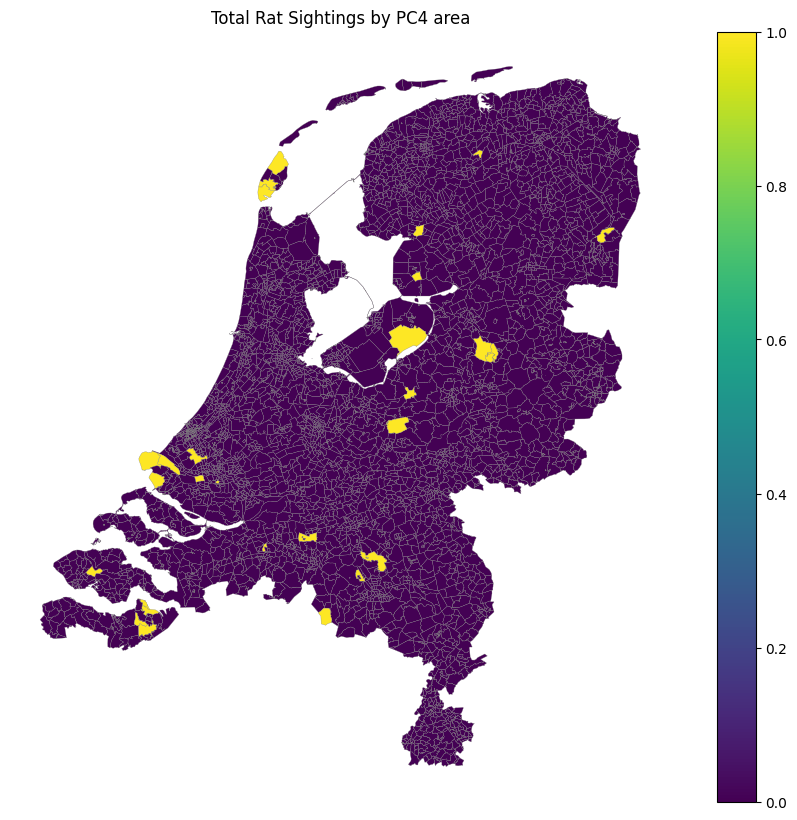

In [23]:
# Plot map with color scale focused on lower end
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

target_df.plot(
    column='TOTAAL',
    cmap='viridis',
    linewidth=0.2,
    edgecolor='grey',
    legend=True,
    ax=ax,
    vmin=0,
    vmax=1,
    missing_kwds={
        "color": "lightgrey",
        "label": "No data"
    }
)
ax.set_title('Total Rat Sightings by PC4 area')
ax.axis('off')
plt.show()

In [ ]:
import folium
from folium import Choropleth

# Prepare GeoDataFrame for folium (ensure geometry is in EPSG:4326)
ml_plot_df = target_df[['geometry', 'TOTAAL']].copy()
ml_plot_df['prob_positive'] = clf.predict_proba(X_pred)[:, 1]
ml_plot_df = ml_plot_df.reset_index()
ml_plot_df = ml_plot_df.to_crs(epsg=4326)

# Create folium map centered on the mean coordinates
center = [ml_plot_df.geometry.centroid.y.mean(), ml_plot_df.geometry.centroid.x.mean()]
m = folium.Map(location=center, zoom_start=8, tiles='cartodbpositron')

# Add polygons colored by predicted probability
Choropleth(
    geo_data=ml_plot_df,
    data=ml_plot_df,
    columns=['postcode', 'prob_positive'],
    key_on='feature.properties.postcode',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Probability of Rat Sighting'
).add_to(m)

# Optionally, add rat sighting counts as popups
for _, row in ml_plot_df.iterrows():
    folium.GeoJson(
        row['geometry'],
        style_function=lambda x, p=row: {
            'fillColor': '#00000000',
            'color': '#00000000',
            'weight': 0
        },
        tooltip=folium.Tooltip(
            f"Postcode: {row['postcode']}<br>"
            f"Probability: {row['prob_positive']:.2f}<br>"
            f"Rat Sightings: {row['TOTAAL']}"
        )
    ).add_to(m)

m